In [1]:
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [2]:
def simple_threshold_data(number_a0, number_a1,
                          a0_threshold, a1_threshold,
                          a0_label, a1_label):

    a0s = np.full(number_a0, a0_label)
    a1s = np.full(number_a1, a1_label)

    a0_scores = np.linspace(0, 1, number_a0)
    a1_scores = np.linspace(0, 1, number_a1)
    score_feature = np.concatenate((a0_scores, a1_scores), axis=None)

    A = np.concatenate((a0s, a1s), axis=None)

    Y_a0 = [x > a0_threshold for x in a0_scores]
    Y_a1 = [x > a1_threshold for x in a1_scores]

    Y = np.concatenate((Y_a0, Y_a1), axis=None)

    X = pd.DataFrame({"credit_score_feature": score_feature,
                      "example_sensitive_feature": A})
    return X, Y, A

In [3]:
num_samples_a0 = 31
num_samples_a1 = 21

a0_threshold= 0.2
a1_threshold = 0.7

a0_label = 2
a1_label = 3

X, Y, A = simple_threshold_data(num_samples_a0, num_samples_a1, a0_threshold, a1_threshold, a0_label, a1_label)

In [4]:
import matplotlib.pyplot as plt
def plot_data(Xs, Ys):
    labels = np.unique(Xs["example_sensitive_feature"])
    
    for l in labels:
        label_string = str(l.item())
        mask = Xs["example_sensitive_feature"] == l
        plt.scatter(Xs[mask].credit_score_feature, Ys[mask], label=str("Label="+label_string))
        plt.xlabel("Credit Score")
        plt.ylabel("Got Loan")
        
    plt.legend()
    plt.show()

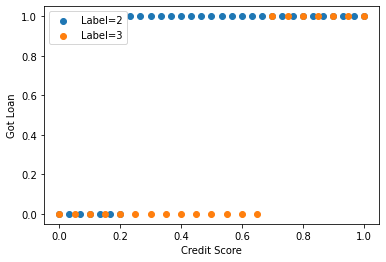

In [5]:
plot_data(X, Y)

In [6]:
unfair_model = LogisticRegression(solver='liblinear', fit_intercept=True)
unfair_model.fit(X, Y, sample_weight=np.ones(len(Y)))

unfair_model.coef_

array([[ 2.87824386, -0.8620337 ]])

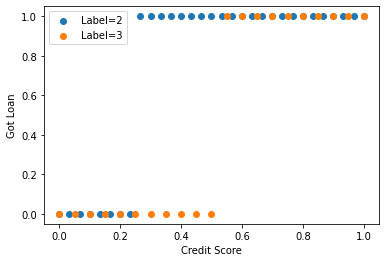

In [7]:
Y_predict_unfair = unfair_model.predict(X)
plot_data(X, Y_predict_unfair)

In [8]:
first_sweep=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                       constraints=DemographicParity(),
                       grid_size=7)

first_sweep.fit(X, Y, sensitive_features=A)

In [9]:
lambda_vecs = first_sweep._lambda_vecs
lambda_vecs[0]

sign  event  group_id
+     all    2           0.0
             3           0.0
-     all    2           2.0
             3           0.0
Name: 0, dtype: float64

In [10]:
actual_multipliers = [lambda_vecs[col][("+", "all", 2)]-lambda_vecs[col][("-", "all", 2)] for col in lambda_vecs]
actual_multipliers

[-2.0,
 -1.3333333333333333,
 -0.6666666666666666,
 0.0,
 0.6666666666666666,
 1.3333333333333333,
 2.0]

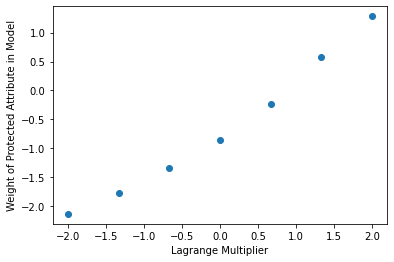

In [11]:
first_sweep_sensitive_feature_weights = [
            predictor.coef_[0][1] for predictor in first_sweep._predictors]
plt.scatter(actual_multipliers, first_sweep_sensitive_feature_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

In [12]:
lambda_best = first_sweep._lambda_vecs[first_sweep._best_grid_index][("+", "all", 2)] - first_sweep._lambda_vecs[first_sweep._best_grid_index][("-", "all", 2)]
print("lambda_best =", lambda_best)
print("coefficients =", first_sweep._predictors[first_sweep._best_grid_index].coef_)

lambda_best = 0.6666666666666666
coefficients = [[ 2.67140771 -0.24157787]]


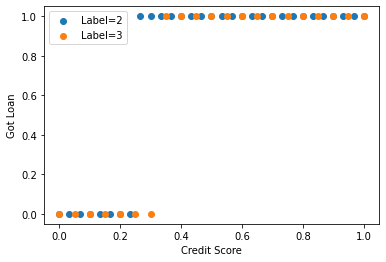

In [13]:
Y_first_predict = first_sweep.predict(X)
plot_data(X, Y_first_predict)

In [14]:
second_sweep_multipliers = np.linspace(lambda_best-0.5, lambda_best+0.5, 31)

iterables = [['+', '-'], ['all'], [a0_label, a1_label]]
midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])

second_sweep_lambdas = []
for l in second_sweep_multipliers:
    nxt = pd.Series(np.zeros(4), index=midx)
    if l < 0:
        nxt[("-", "all", 2)] = abs(l)
    else:
        nxt[("+", "all", 2)] = l
    second_sweep_lambdas.append(nxt)
    
multiplier_df = pd.concat(second_sweep_lambdas,axis=1)

In [15]:
second_sweep=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=multiplier_df)

second_sweep.fit(X, Y, sensitive_features=A)

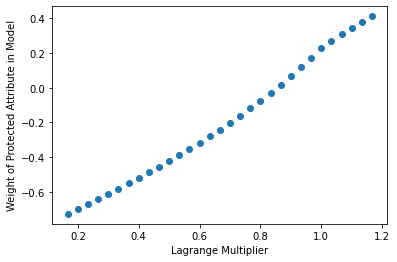

In [16]:
second_sweep_sensitive_feature_weights = [
            predictor.coef_[0][1] for predictor in second_sweep._predictors]
plt.scatter(second_sweep_multipliers, second_sweep_sensitive_feature_weights)
plt.xlabel("Lagrange Multiplier")
plt.ylabel("Weight of Protected Attribute in Model")
plt.show()

In [17]:
lambda_best_second = second_sweep._lambda_vecs[second_sweep._best_grid_index][("+", "all", 2)] \
                     -second_sweep._lambda_vecs[second_sweep._best_grid_index][("-", "all", 2)]
print("lambda_best =", lambda_best_second)
print("coefficients =", second_sweep._predictors[second_sweep._best_grid_index].coef_)

lambda_best = 0.8333333333333333
coefficients = [[ 2.53725364 -0.02969599]]


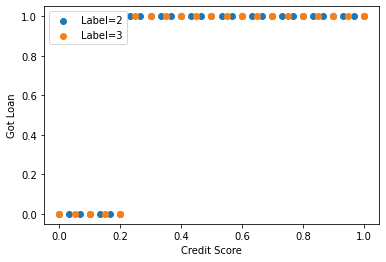

In [18]:
Y_second_predict = second_sweep.predict(X)
plot_data(X, Y_second_predict)